## Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
import glob
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import gc
import shutil
from collections import OrderedDict

In [4]:
plt.set_cmap('Dark2')
data_dir = 'E:/Datasets/Assignment 5 Dataset'
is_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if is_gpu else "cpu")
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 128 # test 128 images at a time
NUM_WORKERS = 6
print(device)

cuda:0


<Figure size 432x288 with 0 Axes>

### Image Transformations

In [5]:
train_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                        transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Load Dataset usign torchvision image loader

In [6]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

print(len(train_data), len(validation_data), len(test_data))

labels = train_data.classes

print("Labels: " , labels)

12000 1500 1500
Labels:  ['infected', 'normal']


### Data Loaders

In [7]:
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

### Utility functions

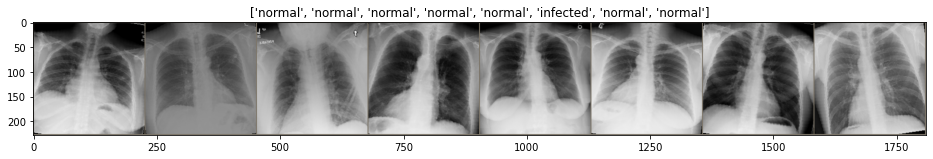

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:8])
    plt.figure(figsize=(16, 8))
    imshow(out, title=[labels[x] for x in classes[:8]])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [9]:
def load_pretrained_model(name='vgg16'):
    
    models_path = 'E:/PreTrained Models'
    Path(models_path).mkdir(parents=True, exist_ok=True)
    print('Loading Model...')
    
    if name == 'vgg16':
        try:
            model = torch.load(models_path + '/vgg16-397923af.pth')
        except:
        
            model = models.vgg16(pretrained=True, progress=True)
            torch.save(model, models_path + '/vgg16-397923af.pth')
            
        for param in model.features.parameters():
            param.requires_grad = False
            
        num_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(nn.Linear(in_features=num_features, out_features = (78 * 10) + 100 , bias=True ),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(p=0.5),
                                      nn.Linear(in_features= (78 * 10) + 100, out_features = len(labels) , bias=True ))
            
    if name == 'resnet18':
        try:
            model = torch.load(models_path + '/resnet18-5c106cde.pth')
        except:
        
            model = models.resnet18(pretrained=True, progress=True)
            torch.save(model, models_path + '/resnet18-5c106cde.pth')
            
        for param in model.parameters():
            param.requires_grad = False
            
        num_features = model.fc.in_features
        model.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(num_features , out_features = (78 * 10) + 100)),
            ('relu', nn.ReLU(inplace=True)),
            ('fc2', nn.Linear(in_features = (78 * 10) + 100, out_features=len(labels)))]))
    
    print('Model Loaded')
    return model

In [10]:
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); 
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);
    plt.show()

In [11]:
def plot_confusion_matrices(cm, labels, titles=[]):
    fig, ax =  plt.subplots(1,len(cm),figsize=(20,5))
    for i in range(len(cm)):
        sns.heatmap(cm[i], annot=True, ax = ax[i], fmt="d", annot_kws={"fontsize":20});
        ax[i].set_xlabel('Predicted labels');
        ax[i].set_ylabel('True labels'); 
        ax[i].set_title(titles[i]); 
        ax[i].xaxis.set_ticklabels(labels);
        ax[i].yaxis.set_ticklabels(labels);
    plt.show()

In [12]:
def predict(model, data_loader):
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, classes = data
            images, classes = images.to(device), classes.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.append(predicted)
            y_true.append(classes)
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    if is_gpu:
        torch.cuda.empty_cache()
    return y_pred, y_true

In [13]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

In [14]:
def evaluate_model(model, data_loader):
    y_pred, y_true = predict(model, data_loader)
    acc = accuracy(y_pred, y_true)
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    tn, fp, fn, tp = cm.ravel()
    recall = tp/(tp + fn)
    precision = tp/((tp + fp))
    f1_score = 2 * (recall * precision)/(precision + recall)

    return y_pred, y_true, acc, cm, f1_score

In [15]:
def plot_loss_and_accuracy_curves(history):
    
    fig, ax =  plt.subplots(1,2,figsize=(20,5))
    
    ax[0].plot(history['train_accuracy'], color='r', label='Train Accuracy')
    ax[0].plot(history['validation_accuracy'], color='g', label='Validation Accuracy')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    
    ax[1].plot(history['train_loss'], color='r', label='Train Loss')
    ax[1].plot(history['validation_loss'], color='g', label='Validation Loss')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    
    plt.show()

In [16]:
def save_model(model_state, model_path):
    torch.save(model_state, model_path)

In [17]:
def load_model(model_path, model, optimizer):
    
    model_state = torch.load(model_path)
    
    model.load_state_dict(model_state['model'])

    optimizer.load_state_dict(model_state['optimizer'])
    
    history = model_state['history']

    return model, optimizer, history

### Model Training Function

In [18]:
def train(model, criterion, optimizer, train_loader, validation_loader, save_path=None, epochs=10, plot_curves=True, history=None):
    model.to(device)
    best_model = copy.deepcopy(model)
    
    if history is None:
        history = {'train_loss': [], 'validation_loss': [], 'train_accuracy': [], 'validation_accuracy': [], 'epochs': 0, 'best_validation_accuracy': -np.inf, 'min_validation_loss': np.inf}
        
    prev_epochs = history['epochs']
    best_validation_accuracy = history['best_validation_accuracy']
    min_validation_loss = history['min_validation_loss']

    total_epochs = prev_epochs + epochs

    for epoch in range(prev_epochs, total_epochs):  # loop over the dataset multiple times
        
        train_loss = 0.0
        validation_loss = 0.0
        
        train_accuracy = 0.0
        validation_accuracy = 0.0
        
        correct = 0
        model.train()
        
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch+1, total_epochs), position=0, leave=True)

        for inputs, classes in train_loader:

            inputs, classes = inputs.to(device), classes.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, classes)   #----> compute loss

            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            # print statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes).sum().item()
            outer.update(len(inputs))
        outer.close()
        train_accuracy = correct / len(train_loader.dataset)
        train_loss = train_loss  / len(train_loader)
        
        #### Validation loss and accuracy
        with torch.no_grad():
            correct = 0
            model.eval()
            
            for inputs, classes in validation_loader:
                inputs, classes = inputs.to(device), classes.to(device)
                outputs = model(inputs)               #----> forward pass
                
                loss = criterion(outputs, classes)   #----> compute loss
                validation_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == classes).sum().item()
                
        validation_accuracy = correct / len(validation_loader.dataset)
        validation_loss = validation_loss / len(validation_loader)
        
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str('Train Loss: {:.6f} | Validation Loss: {:.6f} | Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
        train_loss, validation_loss, train_accuracy , validation_accuracy))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if validation_accuracy >= best_validation_accuracy: 
            best_validation_accuracy = validation_accuracy
            min_validation_loss = validation_loss
            best_model.load_state_dict(model.state_dict())

            torch.save(best_model.state_dict(), './best models/' + save_path)      
            
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['validation_loss'].append(validation_loss)
        history['train_accuracy'].append(train_accuracy)
        history['validation_accuracy'].append(validation_accuracy)
        history['min_validation_loss'] = min_validation_loss
        history['best_validation_accuracy'] = best_validation_accuracy
        
        model_state = {
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
            }
        
        save_model(model_state, './saved models/' + save_path)
        
    if plot_curves:
        plot_loss_and_accuracy_curves(history)
    
    if is_gpu:
        torch.cuda.empty_cache()
        
    return history , best_model

<br><br><br><center><h1>Task 1: VGG16 FC Layers Only Training</h1></center><br><br><br>

In [98]:
vgg16_fc_only = load_pretrained_model('vgg16')

Loading Model...
Model Loaded


## Experiments

In [35]:
vgg16_fc_only_exp_logs = []

### Exp 1: SGD, LR=0.001

Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 169.48it/s]
Train Loss: 0.308653 | Validation Loss: 0.317624 | Train Accuracy: 0.87 | Validation Accuracy: 0.87
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 172.26it/s]
Train Loss: 0.251569 | Validation Loss: 0.291164 | Train Accuracy: 0.90 | Validation Accuracy: 0.89
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 171.49it/s]
Train Loss: 0.238146 | Validation Loss: 0.282268 | Train Accuracy: 0.91 | Validation Accuracy: 0.89
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 171.46it/s]
Train Loss: 0.228498 | Validation Loss: 0.279984 | Train Accuracy: 0.91 | Validation Accuracy: 0.90
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 171.57it/s]


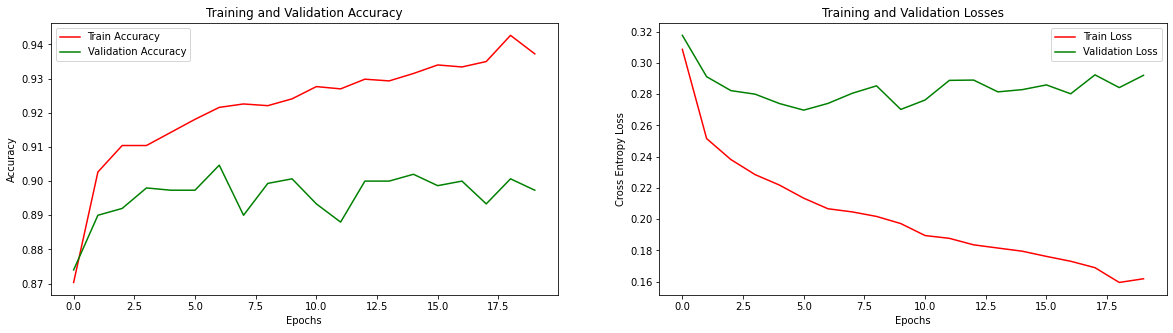

In [36]:
vgg16_fc_only_exp_model = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_exp_criterion = nn.CrossEntropyLoss()
vgg16_fc_only_exp_optimizer = optim.SGD(vgg16_fc_only_exp_model.classifier.parameters(), lr=0.001, momentum=0.9)

vgg16_fc_only_exp_history, vgg16_fc_only_exp_best_model = train(model = vgg16_fc_only_exp_model,
                                       criterion = vgg16_fc_only_exp_criterion,
                                       optimizer = vgg16_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_fc_only_exp_1.pth',
                                       epochs=20)


Train Accuracy: 0.9307 | F1 Score: 0.9423
Validation Accuracy: 0.9047 | F1 Score: 0.9200
Test Accuracy: 0.9520 | F1 Score: 0.9603


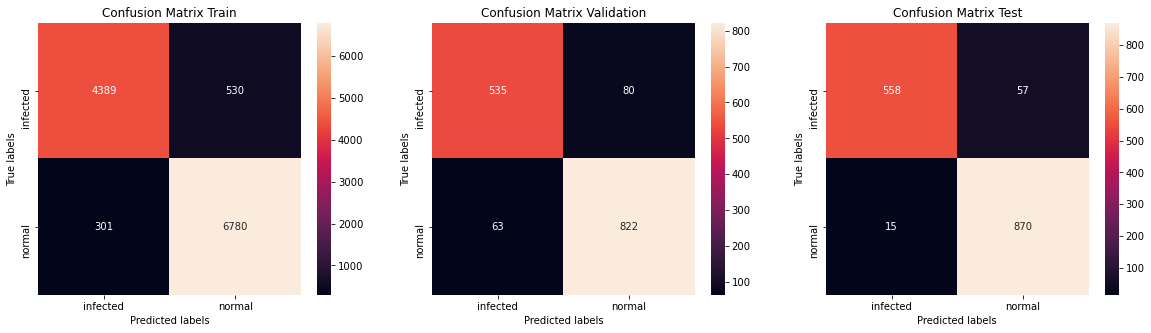

In [37]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_exp_best_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_exp_best_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

vgg16_fc_only_exp_logs.append({'desc': 'SGD, LR 0.001', 'results': results, 'history': vgg16_fc_only_exp_history})


### Exp 2: SGD + Nesterov, LR=0.001

Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 173.08it/s]
Train Loss: 0.308572 | Validation Loss: 0.295850 | Train Accuracy: 0.88 | Validation Accuracy: 0.89
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 169.89it/s]
Train Loss: 0.247953 | Validation Loss: 0.284865 | Train Accuracy: 0.91 | Validation Accuracy: 0.89
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 170.31it/s]
Train Loss: 0.233346 | Validation Loss: 0.317348 | Train Accuracy: 0.91 | Validation Accuracy: 0.87
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 170.18it/s]
Train Loss: 0.224607 | Validation Loss: 0.278824 | Train Accuracy: 0.91 | Validation Accuracy: 0.90
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 169.72it/s]


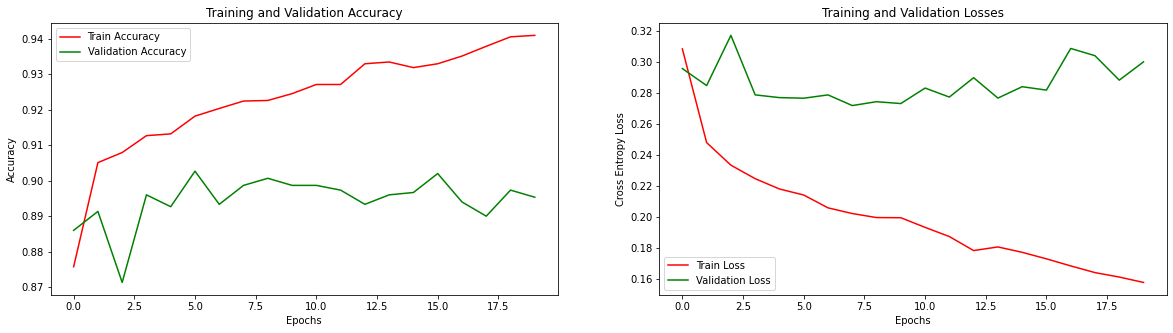

In [39]:
vgg16_fc_only_exp_model = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_exp_criterion = nn.CrossEntropyLoss()
vgg16_fc_only_exp_optimizer = optim.SGD(vgg16_fc_only_exp_model.classifier.parameters(), lr=0.001, momentum=0.9, nesterov=True)

vgg16_fc_only_exp_history, vgg16_fc_only_exp_best_model = train(model = vgg16_fc_only_exp_model,
                                       criterion = vgg16_fc_only_exp_criterion,
                                       optimizer = vgg16_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_fc_only_exp_2.pth',
                                       epochs=20)


Train Accuracy: 0.9264 | F1 Score: 0.9371
Validation Accuracy: 0.9027 | F1 Score: 0.9158
Test Accuracy: 0.9420 | F1 Score: 0.9509


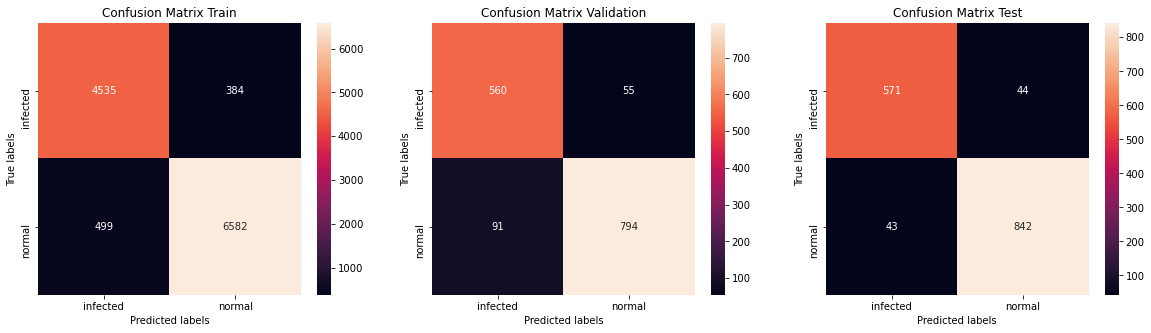

In [40]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_exp_best_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_exp_best_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

vgg16_fc_only_exp_logs.append({'desc': 'SGD + Nesterov, LR 0.001', 'results': results, 'history': vgg16_fc_only_exp_history})


### Exp 3: Adam, LR=0.001

Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 170.62it/s]
Train Loss: 0.478275 | Validation Loss: 0.295341 | Train Accuracy: 0.86 | Validation Accuracy: 0.87
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 169.09it/s]
Train Loss: 0.251448 | Validation Loss: 0.286522 | Train Accuracy: 0.90 | Validation Accuracy: 0.89
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:11<00:00, 168.09it/s]
Train Loss: 0.248487 | Validation Loss: 0.288453 | Train Accuracy: 0.91 | Validation Accuracy: 0.88
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:12<00:00, 164.44it/s]
Train Loss: 0.234896 | Validation Loss: 0.277634 | Train Accuracy: 0.91 | Validation Accuracy: 0.89
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:11<00:00, 167.91it/s]


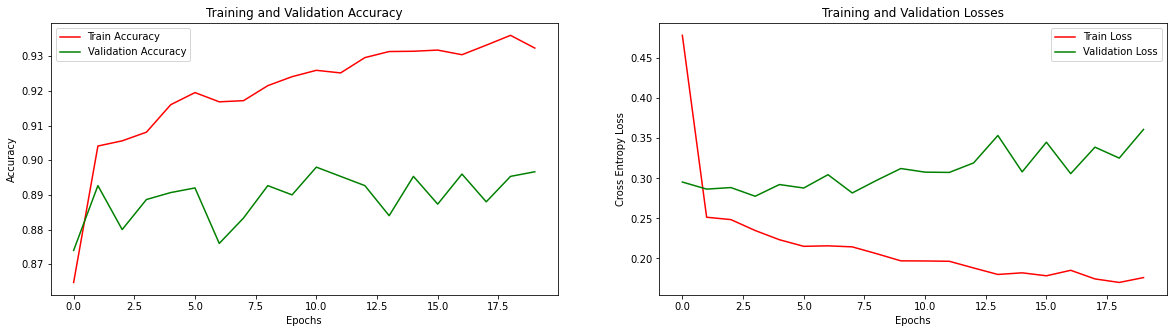

In [41]:
vgg16_fc_only_exp_model = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_exp_criterion = nn.CrossEntropyLoss()
vgg16_fc_only_exp_optimizer = optim.Adam(vgg16_fc_only_exp_model.classifier.parameters(), lr=0.001)

vgg16_fc_only_exp_history, vgg16_fc_only_exp_best_model = train(model = vgg16_fc_only_exp_model,
                                       criterion = vgg16_fc_only_exp_criterion,
                                       optimizer = vgg16_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_fc_only_exp_3.pth',
                                       epochs=20)

Train Accuracy: 0.9397 | F1 Score: 0.9495
Validation Accuracy: 0.8980 | F1 Score: 0.9133
Test Accuracy: 0.9553 | F1 Score: 0.9626


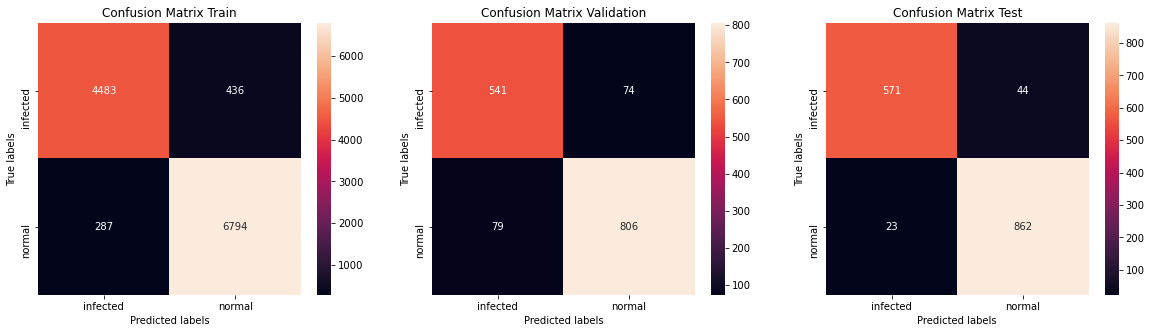

In [42]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_exp_best_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_exp_best_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

vgg16_fc_only_exp_logs.append({'desc': 'Adam, LR 0.001', 'results': results, 'history': vgg16_fc_only_exp_history})


### Exp 4: SGD, LR = 0.0001

Train Epoch: 1 / 30: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 173.60it/s]
Train Loss: 0.425154 | Validation Loss: 0.372082 | Train Accuracy: 0.81 | Validation Accuracy: 0.84
Train Epoch: 2 / 30: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:09<00:00, 171.43it/s]
Train Loss: 0.314128 | Validation Loss: 0.337728 | Train Accuracy: 0.87 | Validation Accuracy: 0.85
Train Epoch: 3 / 30: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 171.19it/s]
Train Loss: 0.289589 | Validation Loss: 0.321514 | Train Accuracy: 0.89 | Validation Accuracy: 0.87
Train Epoch: 4 / 30: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 171.17it/s]
Train Loss: 0.272660 | Validation Loss: 0.313217 | Train Accuracy: 0.89 | Validation Accuracy: 0.88
Train Epoch: 5 / 30: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:10<00:00, 170.98it/s]


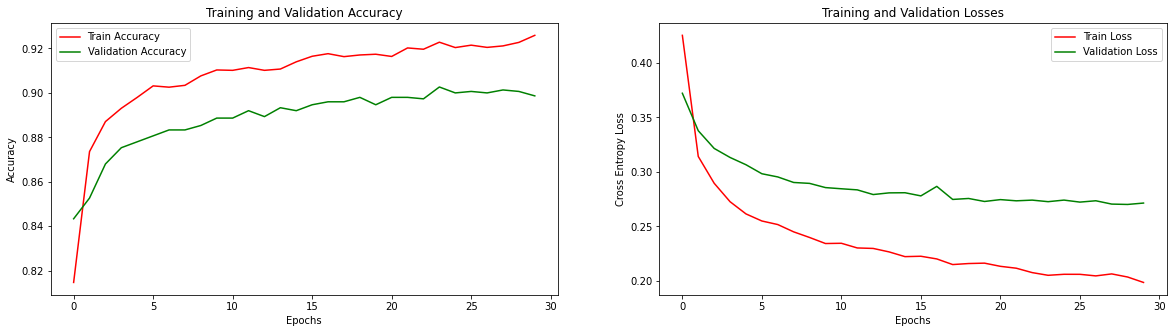

In [43]:
vgg16_fc_only_exp_model = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_exp_criterion = nn.CrossEntropyLoss()
vgg16_fc_only_exp_optimizer = optim.SGD(vgg16_fc_only_exp_model.classifier.parameters(), lr=0.0001, momentum=0.9)

vgg16_fc_only_exp_history, vgg16_fc_only_exp_best_model = train(model = vgg16_fc_only_exp_model,
                                       criterion = vgg16_fc_only_exp_criterion,
                                       optimizer = vgg16_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_fc_only_exp_4.pth',
                                       epochs=30)


Train Accuracy: 0.9227 | F1 Score: 0.9353
Validation Accuracy: 0.9027 | F1 Score: 0.9177
Test Accuracy: 0.9487 | F1 Score: 0.9573


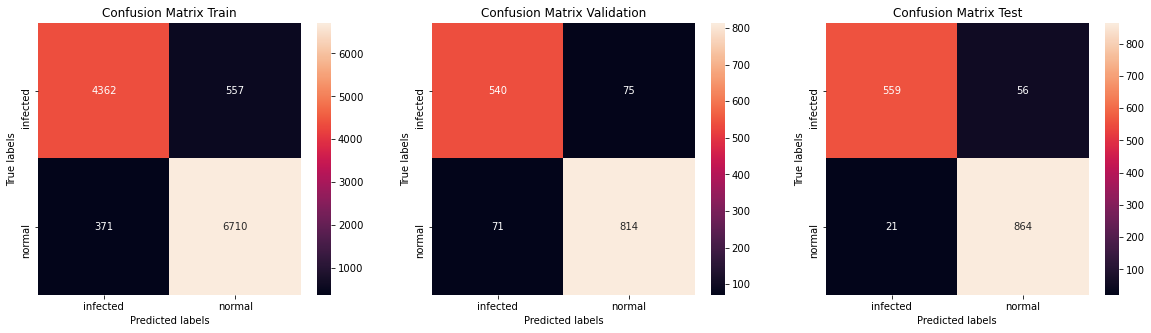

In [44]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_exp_best_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_exp_best_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

vgg16_fc_only_exp_logs.append({'desc': 'SGD, LR 0.0001', 'results': results, 'history': vgg16_fc_only_exp_history})


### Exp 5: SGD + Nesterov, LR = 0.0001

In [ ]:
vgg16_fc_only_exp_model = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_exp_criterion = nn.CrossEntropyLoss()
vgg16_fc_only_exp_optimizer = optim.SGD(vgg16_fc_only_exp_model.classifier.parameters(), lr=0.0001, momentum=0.9)

vgg16_fc_only_exp_history, vgg16_fc_only_exp_best_model = train(model = vgg16_fc_only_exp_model,
                                       criterion = vgg16_fc_only_exp_criterion,
                                       optimizer = vgg16_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_fc_only_exp_5.pth',
                                       epochs=30)

In [ ]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_exp_best_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_exp_best_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_exp_best_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

vgg16_fc_only_exp_logs.append({'desc': 'SGD, LR 0.0001', 'results': results, 'history': vgg16_fc_only_exp_history})

### Combine Accuracy curves for all VGG16 FC ONLY Fine Tuned Model Experiments

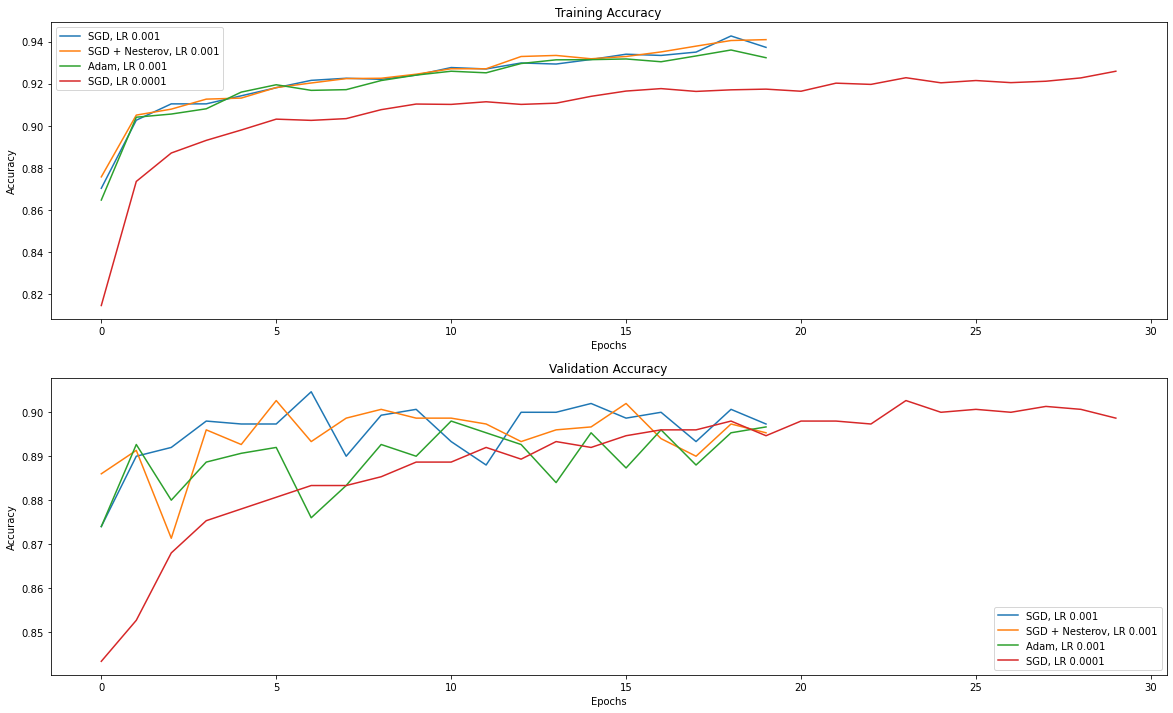

In [45]:
fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in vgg16_fc_only_exp_logs:
    ax[0].plot(log['history']['train_accuracy'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

for log in vgg16_fc_only_exp_logs:
    ax[1].plot(log['history']['validation_accuracy'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].legend()

plt.show()

### Combine Loss curves for all VGG16 FC ONLY Fine Tuned Model Experiments

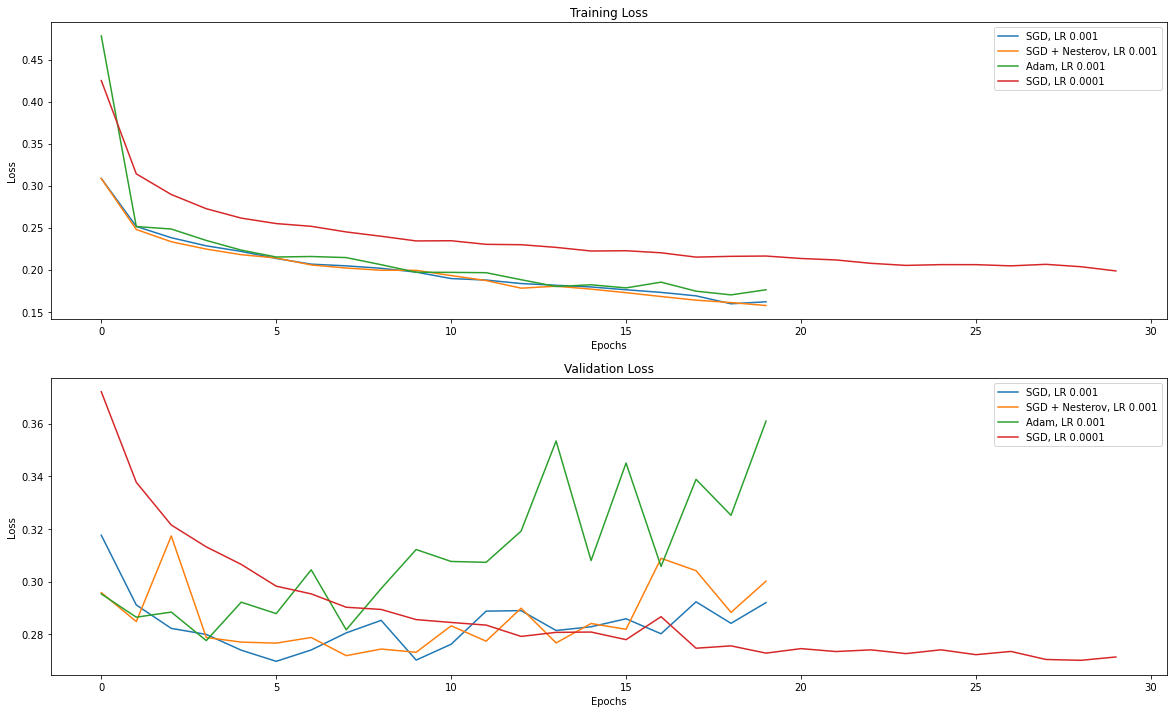

In [51]:
fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in vgg16_fc_only_exp_logs:
    ax[0].plot(log['history']['train_loss'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

for log in vgg16_fc_only_exp_logs:
    ax[1].plot(log['history']['validation_loss'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[1].legend()

plt.show()

### Comparing Best Trained Model during each Experiment

In [54]:
vgg16_fc_only_exp_results_df = pd.DataFrame([log['results'] for log in vgg16_fc_only_exp_logs])
vgg16_fc_only_exp_results_df.insert(loc=0, column='Experiment', value=[i+1 for i in range(len(vgg16_fc_only_exp_logs))])
vgg16_fc_only_exp_results_df.insert(loc=1, column='Desc', value=[log['desc'] for log in vgg16_fc_only_exp_logs]) 

vgg16_fc_only_exp_results_df.sort_values(['acc_test', 'acc_val'], ascending=[False, False])

,Experiment,Desc,acc_train,acc_val,acc_test,f1_score_train,f1_score_val,f1_score_test
2,3,"Adam, LR 0.001",0.939750,0.898000,0.955333,0.949479,0.913314,0.962591
0,1,"SGD, LR 0.001",0.930750,0.904667,0.952000,0.942256,0.919978,0.960265
3,4,"SGD, LR 0.0001",0.922667,0.902667,0.948667,0.935322,0.917700,0.957341
1,2,"SGD + Nesterov, LR 0.001",0.926417,0.902667,0.942000,0.937140,0.915802,0.950875


From Table, Experiment 3 gives best trained model.

### Saving best model

In [32]:
# model trained in experiment 3 is best one and already saved on disk, so just making copy of it with new name
shutil.copy2('best models/vgg16_fc_only_exp_3.pth', 'vgg16_FC_Only.pth')

'vgg16_FC_Only.pth'

### Loading Best model from disk

In [38]:
vgg16_fc_only_best = copy.deepcopy(vgg16_fc_only)
vgg16_fc_only_best.load_state_dict(torch.load('vgg16_FC_Only.pth'))
vgg16_fc_only_best.to(device)
print('Model Loaded')

Model Loaded


### Testing Loaded model

Train Accuracy: 0.9411 | F1 Score: 0.9505
Validation Accuracy: 0.8980 | F1 Score: 0.9133
Test Accuracy: 0.9553 | F1 Score: 0.9626


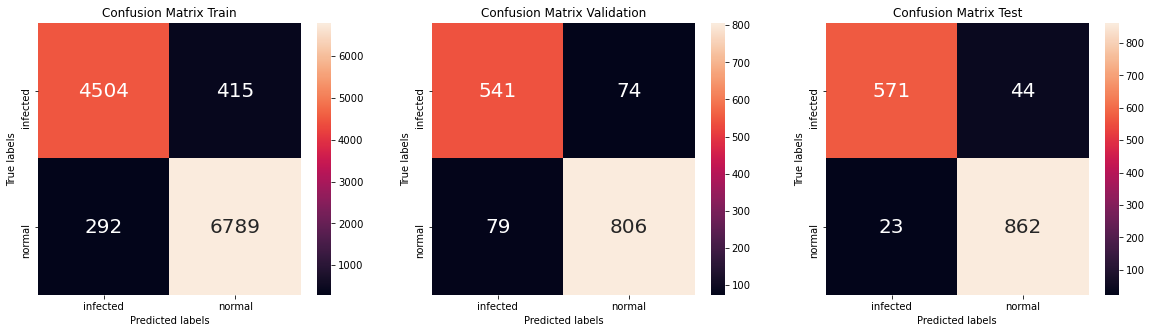

In [39]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_fc_only_best, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_fc_only_best, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_fc_only_best, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])


<br><br><br><center><h1>Task 1: ResNet18 FC Layers Only Training</h1></center><br><br><br>

In [19]:
resnet18_fc_only = load_pretrained_model('resnet18')

Loading Model...
Model Loaded


## Experiments

In [22]:
resnet18_fc_only_exp_logs = []

Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 252.42it/s]
Train Loss: 0.435205 | Validation Loss: 0.378617 | Train Accuracy: 0.81 | Validation Accuracy: 0.83
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:49<00:00, 240.87it/s]
Train Loss: 0.333242 | Validation Loss: 0.350771 | Train Accuracy: 0.86 | Validation Accuracy: 0.85
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:49<00:00, 242.75it/s]
Train Loss: 0.316616 | Validation Loss: 0.345773 | Train Accuracy: 0.87 | Validation Accuracy: 0.85
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:50<00:00, 238.78it/s]
Train Loss: 0.307638 | Validation Loss: 0.340500 | Train Accuracy: 0.87 | Validation Accuracy: 0.86
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:51<00:00, 232.16it/s]


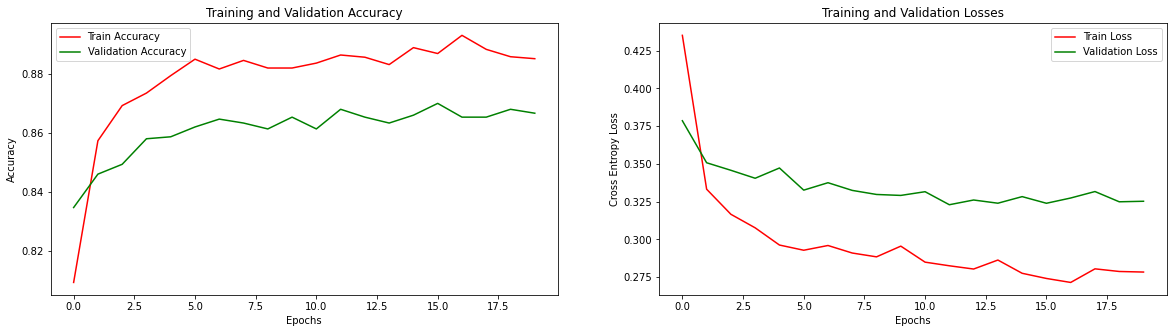

In [24]:
resnet18_fc_only_exp_model = copy.deepcopy(resnet18_fc_only)
resnet18_fc_only_exp_criterion = nn.CrossEntropyLoss()
resnet18_fc_only_exp_optimizer = optim.SGD(resnet18_fc_only_exp_model.fc.parameters(), lr=0.001, momentum=0.9)

resnet18_fc_only_exp_history, resnet18_fc_only_exp_best_model = train(model = resnet18_fc_only_exp_model,
                                       criterion = resnet18_fc_only_exp_criterion,
                                       optimizer = resnet18_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_fc_only_exp_1.pth',
                                       epochs=20)

Train Accuracy: 0.8930 | F1 Score: 0.9091
Validation Accuracy: 0.8667 | F1 Score: 0.8864
Test Accuracy: 0.9333 | F1 Score: 0.9441


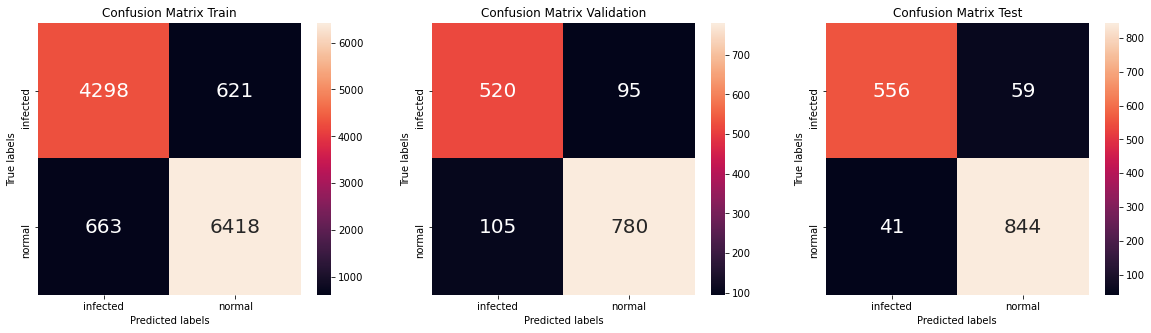

In [29]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_fc_only_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_fc_only_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_fc_only_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': 'SGD, LR 0.001', 'results': results, 'history': resnet18_fc_only_exp_history})


Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:46<00:00, 260.24it/s]
Train Loss: 0.431198 | Validation Loss: 0.376953 | Train Accuracy: 0.81 | Validation Accuracy: 0.83
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.63it/s]
Train Loss: 0.326213 | Validation Loss: 0.355374 | Train Accuracy: 0.87 | Validation Accuracy: 0.84
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.60it/s]
Train Loss: 0.314424 | Validation Loss: 0.348092 | Train Accuracy: 0.87 | Validation Accuracy: 0.86
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 251.18it/s]
Train Loss: 0.307197 | Validation Loss: 0.335163 | Train Accuracy: 0.87 | Validation Accuracy: 0.85
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.16it/s]


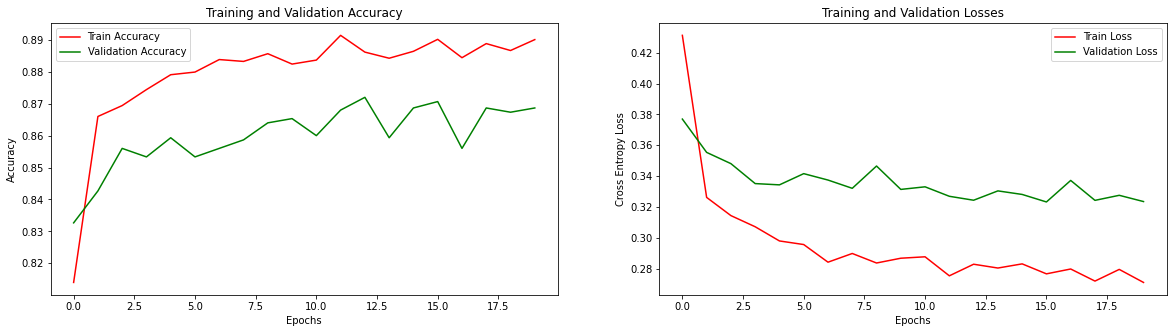

In [40]:
resnet18_fc_only_exp_model = copy.deepcopy(resnet18_fc_only)
resnet18_fc_only_exp_criterion = nn.CrossEntropyLoss()
resnet18_fc_only_exp_optimizer = optim.SGD(resnet18_fc_only_exp_model.fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)

resnet18_fc_only_exp_history, resnet18_fc_only_exp_best_model = train(model = resnet18_fc_only_exp_model,
                                       criterion = resnet18_fc_only_exp_criterion,
                                       optimizer = resnet18_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_fc_only_exp_2.pth',
                                       epochs=20)

Train Accuracy: 0.8957 | F1 Score: 0.9131
Validation Accuracy: 0.8687 | F1 Score: 0.8907
Test Accuracy: 0.9340 | F1 Score: 0.9452


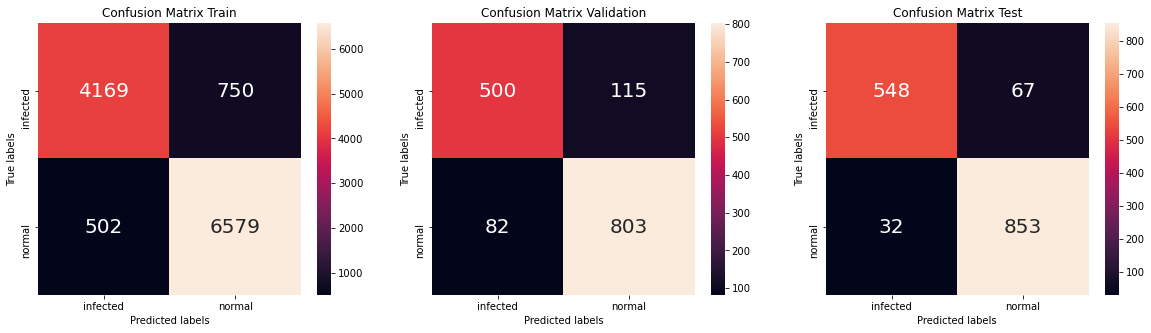

In [41]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_fc_only_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_fc_only_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_fc_only_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': 'SGD + Nesterov, LR 0.001', 'results': results, 'history': resnet18_fc_only_exp_history})


Train Epoch: 1 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:44<00:00, 269.45it/s]
Train Loss: 0.372919 | Validation Loss: 0.339758 | Train Accuracy: 0.84 | Validation Accuracy: 0.85
Train Epoch: 2 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 226.46it/s]
Train Loss: 0.316294 | Validation Loss: 0.365538 | Train Accuracy: 0.87 | Validation Accuracy: 0.85
Train Epoch: 3 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:48<00:00, 247.80it/s]
Train Loss: 0.306539 | Validation Loss: 0.330139 | Train Accuracy: 0.87 | Validation Accuracy: 0.87
Train Epoch: 4 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.00it/s]
Train Loss: 0.297367 | Validation Loss: 0.346496 | Train Accuracy: 0.88 | Validation Accuracy: 0.86
Train Epoch: 5 / 20: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 251.84it/s]


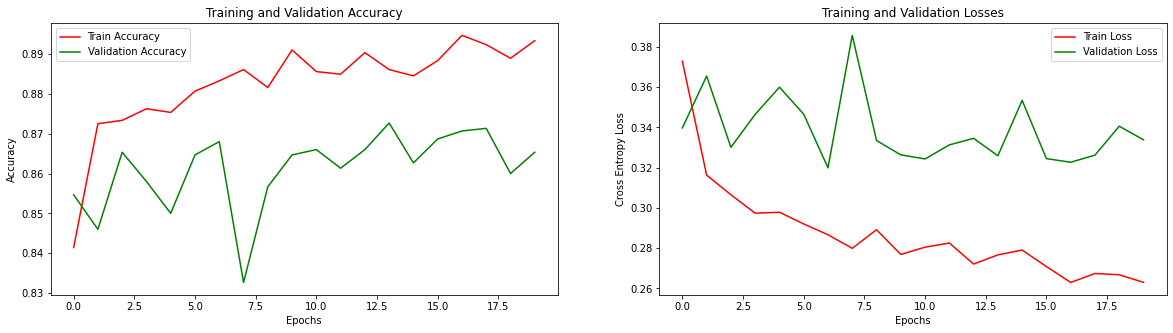

In [42]:
resnet18_fc_only_exp_model = copy.deepcopy(resnet18_fc_only)
resnet18_fc_only_exp_criterion = nn.CrossEntropyLoss()
resnet18_fc_only_exp_optimizer = optim.Adam(resnet18_fc_only_exp_model.fc.parameters(), lr=0.001)

resnet18_fc_only_exp_history, resnet18_fc_only_exp_best_model = train(model = resnet18_fc_only_exp_model,
                                       criterion = resnet18_fc_only_exp_criterion,
                                       optimizer = resnet18_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_fc_only_exp_3.pth',
                                       epochs=20)

Train Accuracy: 0.8999 | F1 Score: 0.9160
Validation Accuracy: 0.8653 | F1 Score: 0.8851
Test Accuracy: 0.9373 | F1 Score: 0.9475


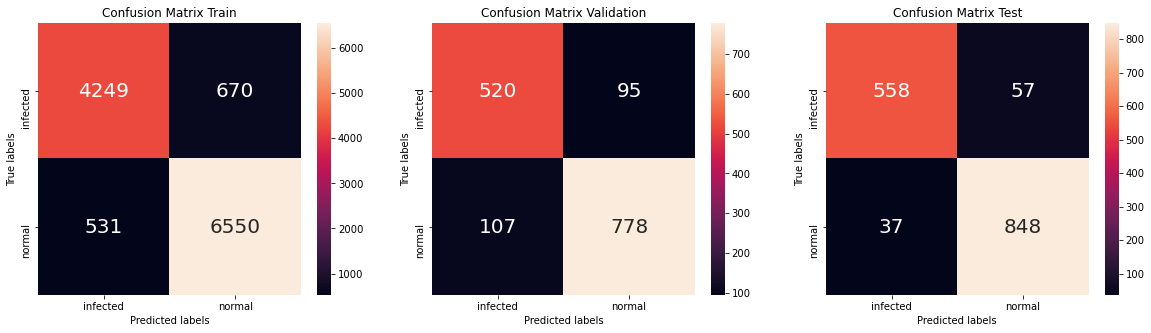

In [43]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_fc_only_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_fc_only_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_fc_only_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': 'Adam, LR 0.001', 'results': results, 'history': resnet18_fc_only_exp_history})


Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 228.95it/s]
Train Loss: 0.612348 | Validation Loss: 0.545800 | Train Accuracy: 0.66 | Validation Accuracy: 0.75
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:53<00:00, 224.49it/s]
Train Loss: 0.500282 | Validation Loss: 0.475759 | Train Accuracy: 0.82 | Validation Accuracy: 0.80
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:49<00:00, 240.41it/s]
Train Loss: 0.442845 | Validation Loss: 0.439121 | Train Accuracy: 0.83 | Validation Accuracy: 0.81
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:48<00:00, 246.35it/s]
Train Loss: 0.411975 | Validation Loss: 0.415270 | Train Accuracy: 0.84 | Validation Accuracy: 0.82
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:48<00:00, 246.89it/s]


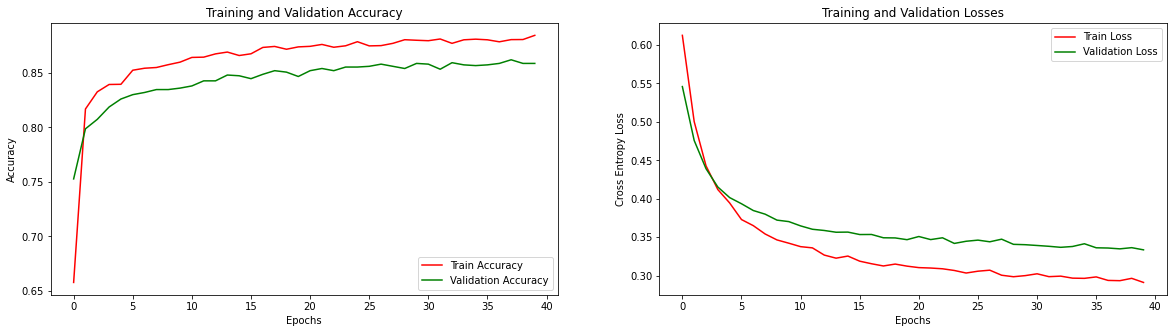

In [23]:
resnet18_fc_only_exp_model = copy.deepcopy(resnet18_fc_only)
resnet18_fc_only_exp_criterion = nn.CrossEntropyLoss()
resnet18_fc_only_exp_optimizer = optim.SGD(resnet18_fc_only_exp_model.fc.parameters(), lr=0.0001, momentum=0.9)

resnet18_fc_only_exp_history, resnet18_fc_only_exp_best_model = train(model = resnet18_fc_only_exp_model,
                                       criterion = resnet18_fc_only_exp_criterion,
                                       optimizer = resnet18_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_fc_only_exp_4.pth',
                                       epochs=40)

Train Accuracy: 0.8849 | F1 Score: 0.9029
Validation Accuracy: 0.8587 | F1 Score: 0.8812
Test Accuracy: 0.9260 | F1 Score: 0.9380


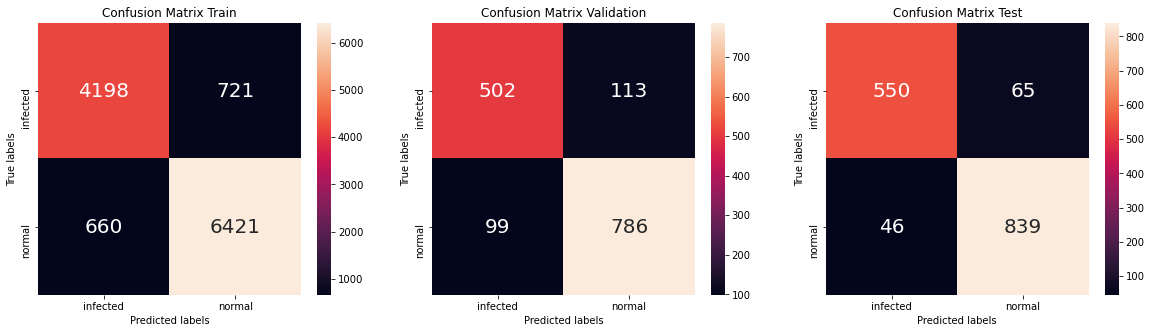

In [24]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_fc_only_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_fc_only_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_fc_only_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': 'SGD, LR 0.0001', 'results': results, 'history': resnet18_fc_only_exp_history})


Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:43<00:00, 274.10it/s]
Train Loss: 0.370376 | Validation Loss: 0.360440 | Train Accuracy: 0.84 | Validation Accuracy: 0.85
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:46<00:00, 257.29it/s]
Train Loss: 0.311713 | Validation Loss: 0.330952 | Train Accuracy: 0.87 | Validation Accuracy: 0.86
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:46<00:00, 255.60it/s]
Train Loss: 0.302948 | Validation Loss: 0.348899 | Train Accuracy: 0.88 | Validation Accuracy: 0.85
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.97it/s]
Train Loss: 0.295999 | Validation Loss: 0.329206 | Train Accuracy: 0.88 | Validation Accuracy: 0.86
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:47<00:00, 250.61it/s]


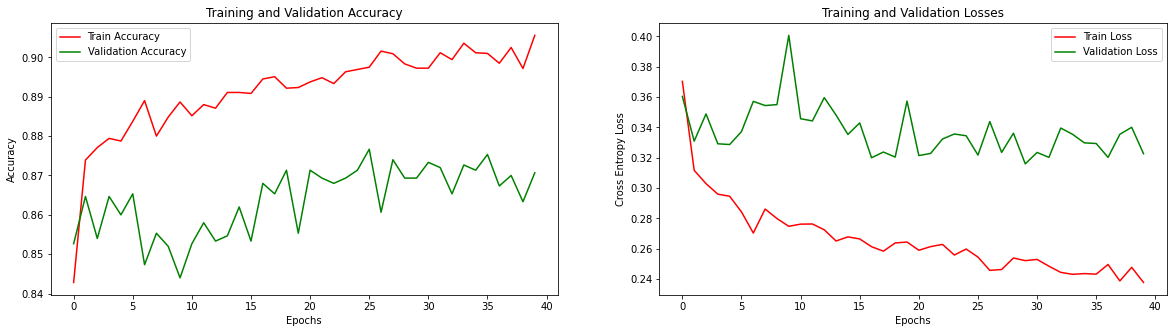

In [25]:
resnet18_fc_only_exp_model = copy.deepcopy(resnet18_fc_only)
resnet18_fc_only_exp_criterion = nn.CrossEntropyLoss()
resnet18_fc_only_exp_optimizer = optim.Adam(resnet18_fc_only_exp_model.fc.parameters(), lr=0.0005)

resnet18_fc_only_exp_history, resnet18_fc_only_exp_best_model = train(model = resnet18_fc_only_exp_model,
                                       criterion = resnet18_fc_only_exp_criterion,
                                       optimizer = resnet18_fc_only_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_fc_only_exp_5.pth',
                                       epochs=40)

Train Accuracy: 0.9120 | F1 Score: 0.9261
Validation Accuracy: 0.8707 | F1 Score: 0.8909
Test Accuracy: 0.9380 | F1 Score: 0.9481


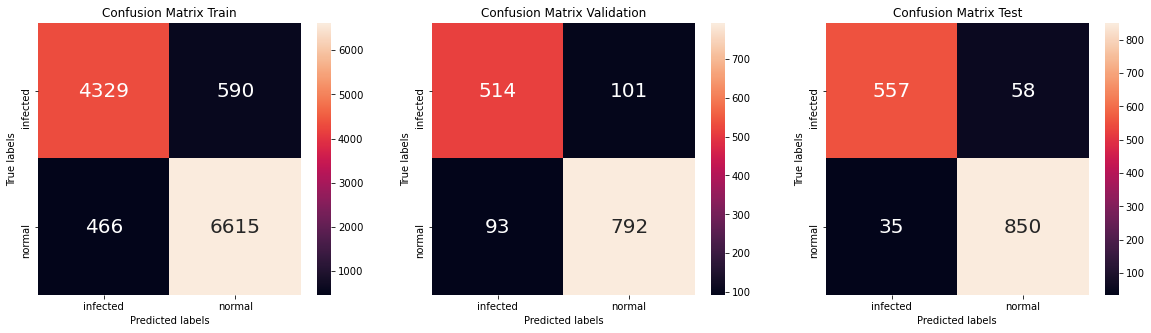

In [26]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_fc_only_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_fc_only_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_fc_only_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': 'Adam, LR 0.0005', 'results': results, 'history': resnet18_fc_only_exp_history})


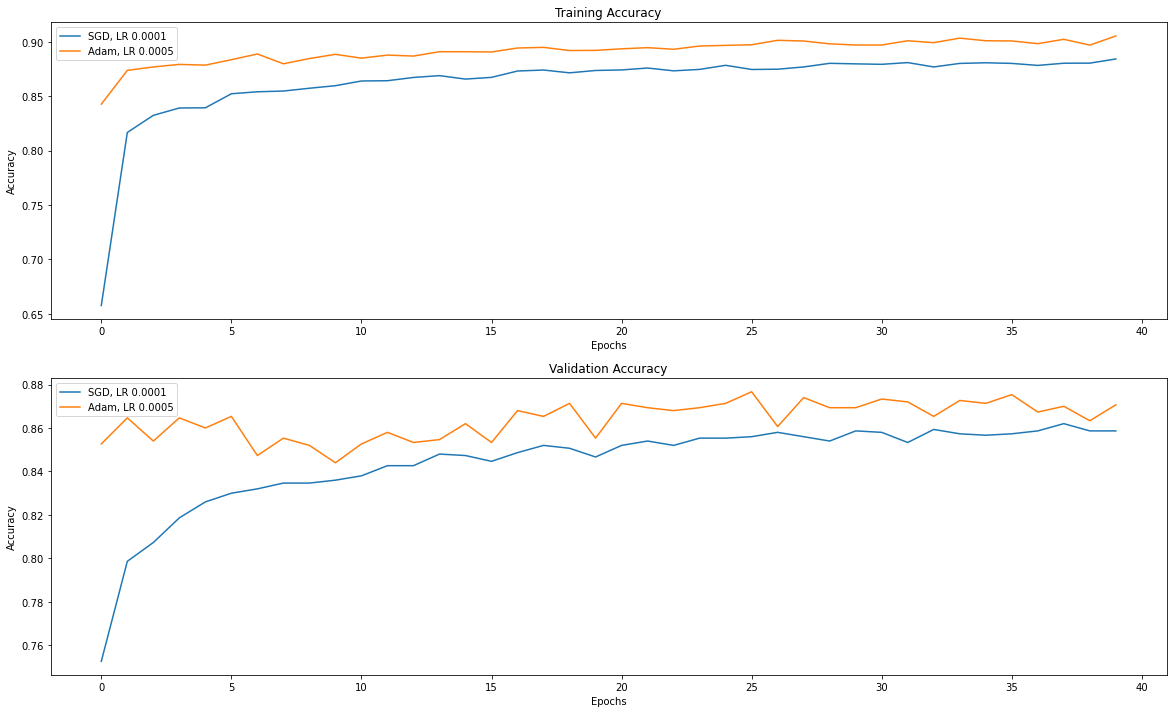

In [27]:
fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in resnet18_fc_only_exp_logs:
    ax[0].plot(log['history']['train_accuracy'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

for log in resnet18_fc_only_exp_logs:
    ax[1].plot(log['history']['validation_accuracy'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].legend()

plt.show()

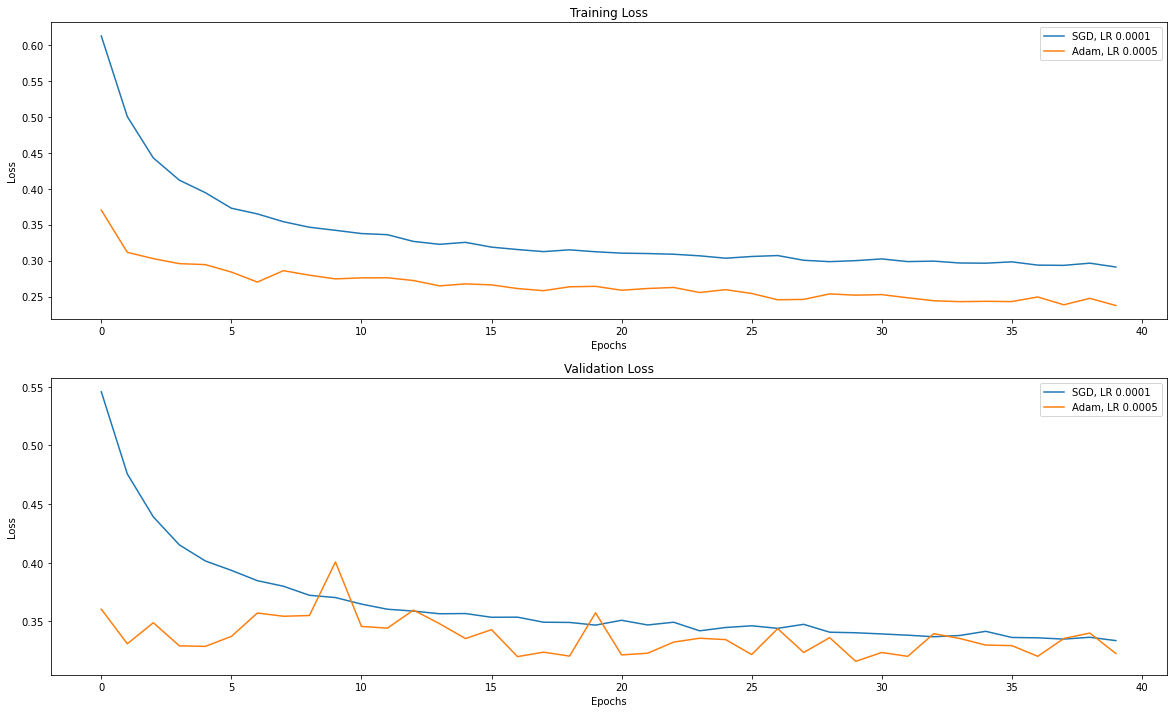

In [28]:
fig, ax =  plt.subplots(2,1,figsize=(20,12))
for log in resnet18_fc_only_exp_logs:
    ax[0].plot(log['history']['train_loss'], label=log['desc'])


ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

for log in resnet18_fc_only_exp_logs:
    ax[1].plot(log['history']['validation_loss'], label=log['desc'])


ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[1].legend()

plt.show()

In [29]:
resnet18_fc_only_exp_results_df = pd.DataFrame([log['results'] for log in resnet18_fc_only_exp_logs])
resnet18_fc_only_exp_results_df.insert(loc=0, column='Experiment', value=[i+1 for i in range(len(resnet18_fc_only_exp_logs))])
resnet18_fc_only_exp_results_df.insert(loc=1, column='Desc', value=[log['desc'] for log in resnet18_fc_only_exp_logs]) 

resnet18_fc_only_exp_results_df.sort_values(['acc_test', 'acc_val'], ascending=[False, False])

,Experiment,Desc,acc_train,acc_val,acc_test,f1_score_train,f1_score_val,f1_score_test
1,2,"Adam, LR 0.0005",0.912000,0.870667,0.938,0.926081,0.890889,0.948132
0,1,"SGD, LR 0.0001",0.884917,0.858667,0.926,0.902904,0.881166,0.937954


In [30]:
# model trained in experiment 3 is best one and already saved on disk, so just making copy of it with new name
shutil.copy2('best models/resnet18_fc_only_exp_5.pth', 'resnet18_FC_Only.pth')

'resnet18_FC_Only.pth'

<br><br><br><center><h1>Task 2: VGG16 Entire NN Training</h1></center><br><br><br>

In [35]:
def unfreeze_vgg16_conv_layers(model, num):
    num_features = 13 #vgg16 has 13 conv layers
    count= num_features - num
    layer_num = 0
    for child in model.features.children():
        if (len(list(child.parameters()))>0):
            layer_num+=1
            if layer_num > count:
                for param in child.parameters():
                    param.requires_grad = True

In [99]:
vgg16_entire = load_pretrained_model('vgg16')

vgg16_entire

Loading Model...
Model Loaded


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Experiments

In [37]:
vgg16_entire_exp_logs = []

### EXP 1: VGG16 single conv layer

Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:13<00:00, 163.58it/s]
Train Loss: 0.308860 | Validation Loss: 0.303980 | Train Accuracy: 0.87 | Validation Accuracy: 0.88
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:13<00:00, 162.99it/s]
Train Loss: 0.240261 | Validation Loss: 0.311791 | Train Accuracy: 0.91 | Validation Accuracy: 0.87
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:13<00:00, 163.03it/s]
Train Loss: 0.222388 | Validation Loss: 0.279194 | Train Accuracy: 0.91 | Validation Accuracy: 0.89
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:13<00:00, 163.25it/s]
Train Loss: 0.208173 | Validation Loss: 0.265605 | Train Accuracy: 0.92 | Validation Accuracy: 0.90
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:13<00:00, 162.88it/s]


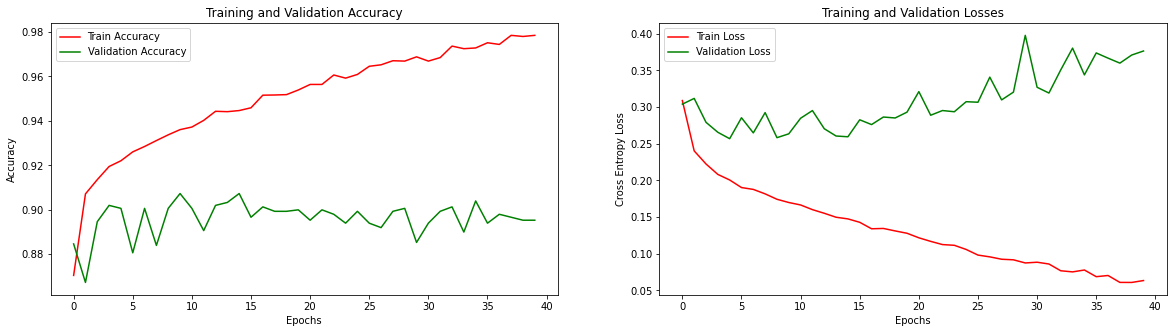

In [38]:
vgg16_entire_exp_model = copy.deepcopy(vgg16_entire)

# unfreezing 1 Conv Layer
unfreeze_vgg16_conv_layers(vgg16_entire_exp_model, 1)

vgg16_entire_exp_criterion = nn.CrossEntropyLoss()

vgg16_entire_exp_optimizer = optim.SGD(vgg16_entire_exp_model.parameters(), lr=0.001, momentum=0.9)

vgg16_entire_exp_history, vgg16_entire_exp_best_model = train(model = vgg16_entire_exp_model,
                                       criterion = vgg16_entire_exp_criterion,
                                       optimizer = vgg16_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_entire_exp_1.pth',
                                       epochs=40)

Train Accuracy: 0.9858 | F1 Score: 0.9880
Validation Accuracy: 0.8953 | F1 Score: 0.9125
Test Accuracy: 0.9620 | F1 Score: 0.9684


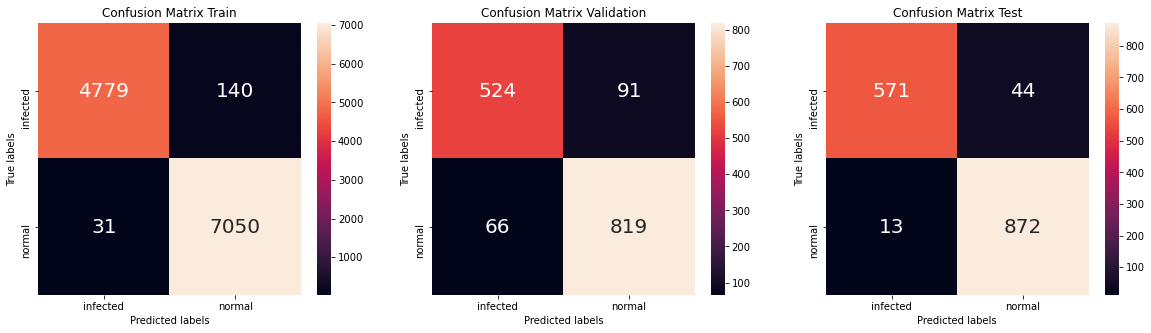

In [39]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': '1 Conv Layer', 'results': results, 'history': vgg16_entire_exp_history})


### EXP 2: VGG16 half conv layers

Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:42<00:00, 116.55it/s]
Train Loss: 0.268818 | Validation Loss: 0.227446 | Train Accuracy: 0.89 | Validation Accuracy: 0.91
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:44<00:00, 115.29it/s]
Train Loss: 0.192525 | Validation Loss: 0.251380 | Train Accuracy: 0.93 | Validation Accuracy: 0.90
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:44<00:00, 114.78it/s]
Train Loss: 0.164955 | Validation Loss: 0.210259 | Train Accuracy: 0.94 | Validation Accuracy: 0.92
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:44<00:00, 115.23it/s]
Train Loss: 0.156639 | Validation Loss: 0.205933 | Train Accuracy: 0.94 | Validation Accuracy: 0.91
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [01:44<00:00, 115.00it/s]


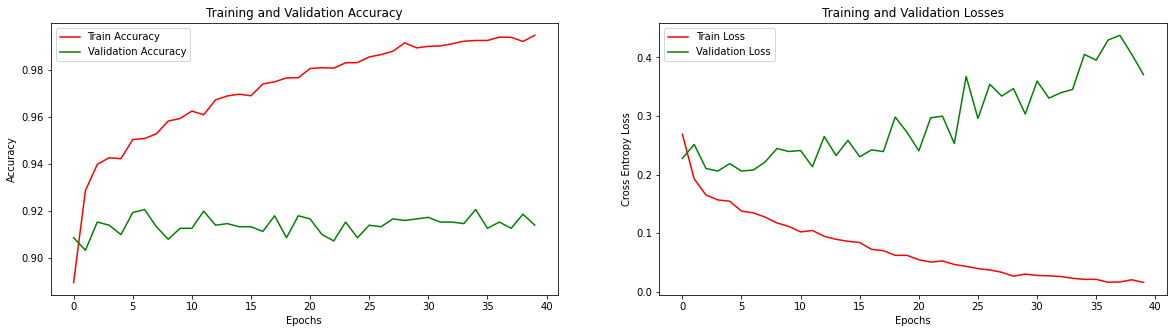

In [40]:
vgg16_entire_exp_model = copy.deepcopy(vgg16_entire)

# unfreezing 7 Conv Layers
unfreeze_vgg16_conv_layers(vgg16_entire_exp_model, 7)

vgg16_entire_exp_criterion = nn.CrossEntropyLoss()

vgg16_entire_exp_optimizer = optim.SGD(vgg16_entire_exp_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

vgg16_entire_exp_history, vgg16_entire_exp_best_model = train(model = vgg16_entire_exp_model,
                                       criterion = vgg16_entire_exp_criterion,
                                       optimizer = vgg16_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_entire_exp_2.pth',
                                       epochs=40)

Train Accuracy: 0.9978 | F1 Score: 0.9982
Validation Accuracy: 0.9140 | F1 Score: 0.9281
Test Accuracy: 0.9713 | F1 Score: 0.9759


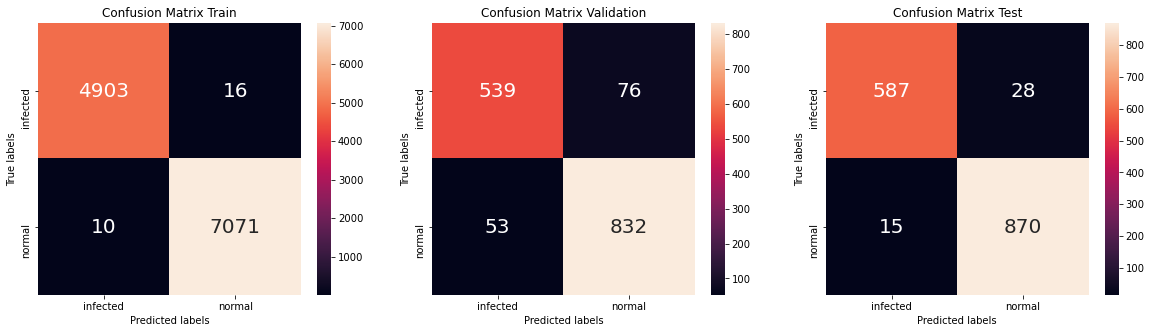

In [41]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_fc_only_exp_logs.append({'desc': '7 Conv Layers', 'results': results, 'history': vgg16_entire_exp_history})


### EXP 3: VGG16 entire network

In [73]:
# del vgg16_fc_only
# del vgg16_fc_only_exp_model
# del vgg16_fc_only_exp_optimizer
# del vgg16_fc_only_exp_best_model

# del resnet18_fc_only_exp_model
# del resnet18_fc_only_exp_optimizer
# del resnet18_fc_only_exp_best_model

# del vgg16_entire_exp_model
# del vgg16_entire_exp_best_model
# del vgg16_entire_exp_optimizer
del vgg16_entire_exp_criterion
gc.collect()
torch.cuda.empty_cache()

In [74]:
# redefining dataloders with small batch size as number of parameters are increased now.
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)

Train Epoch: 1 / 10: 100%|███████████████████████████████████████████████████████| 12000/12000 [03:33<00:00, 56.18it/s]
Train Loss: 0.233240 | Validation Loss: 0.231444 | Train Accuracy: 0.91 | Validation Accuracy: 0.91
Train Epoch: 2 / 10: 100%|███████████████████████████████████████████████████████| 12000/12000 [03:33<00:00, 56.22it/s]
Train Loss: 0.185203 | Validation Loss: 0.222466 | Train Accuracy: 0.93 | Validation Accuracy: 0.92
Train Epoch: 3 / 10: 100%|███████████████████████████████████████████████████████| 12000/12000 [03:33<00:00, 56.11it/s]
Train Loss: 0.159650 | Validation Loss: 0.211144 | Train Accuracy: 0.94 | Validation Accuracy: 0.92
Train Epoch: 4 / 10: 100%|███████████████████████████████████████████████████████| 12000/12000 [03:33<00:00, 56.17it/s]
Train Loss: 0.148074 | Validation Loss: 0.241360 | Train Accuracy: 0.95 | Validation Accuracy: 0.91
Train Epoch: 5 / 10: 100%|███████████████████████████████████████████████████████| 12000/12000 [03:33<00:00, 56.08it/s]


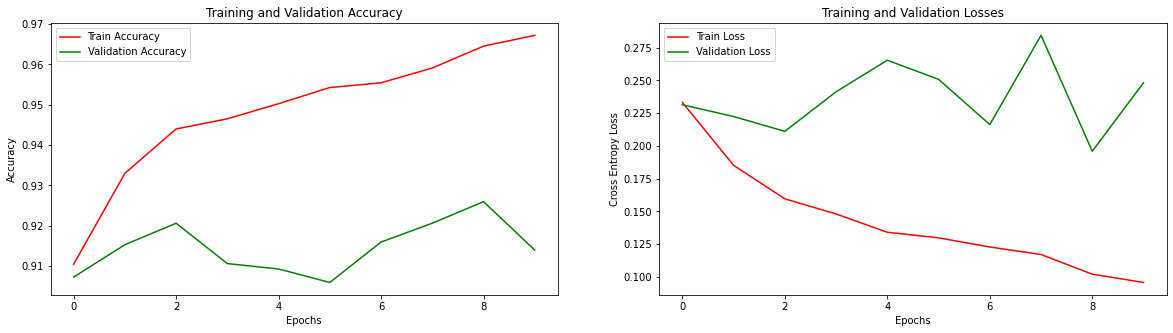

In [75]:
vgg16_entire_exp_model = copy.deepcopy(vgg16_entire)

# unfreezing all 13 Conv Layers
unfreeze_vgg16_conv_layers(vgg16_entire_exp_model, 13)

vgg16_entire_exp_criterion = nn.CrossEntropyLoss()

vgg16_entire_exp_optimizer = optim.Adam(vgg16_entire_exp_model.parameters(), lr=0.0001, weight_decay=0.00001)

vgg16_entire_exp_history, vgg16_entire_exp_best_model = train(model = vgg16_entire_exp_model,
                                       criterion = vgg16_entire_exp_criterion,
                                       optimizer = vgg16_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'vgg16_entire_exp_3.pth',
                                       epochs=10)

Train Accuracy: 0.9696 | F1 Score: 0.9747
Validation Accuracy: 0.9140 | F1 Score: 0.9287
Test Accuracy: 0.9773 | F1 Score: 0.9809


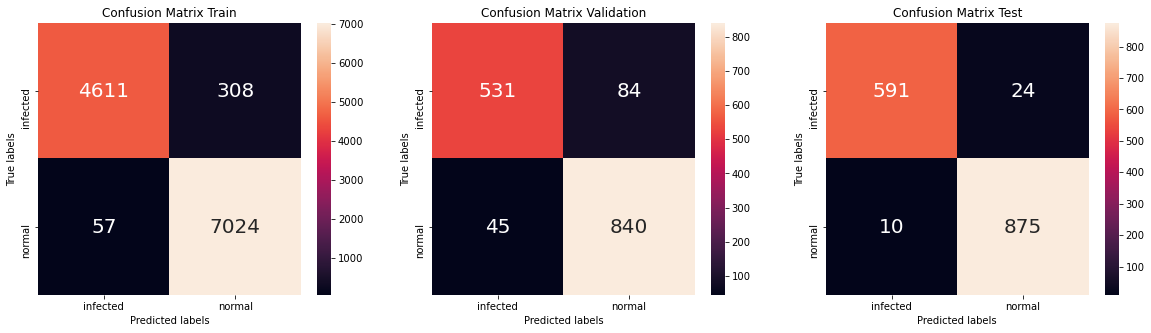

In [76]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(vgg16_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(vgg16_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(vgg16_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

# resnet18_fc_only_exp_logs.append({'desc': '7 Conv Layers', 'results': results, 'history': vgg16_entire_exp_history})


In [ ]:
# model trained in experiment 3 is entire trained model and already saved on disk, so just making copy of it with new name
shutil.copy2('best models/vgg16_entire_exp_3.pth', 'vgg16_entire.pth')

<br><br><br><center><h1>Task 2: ResNet18 Entire NN Training</h1></center><br><br><br>

## Experiments

In [86]:
resnet18_entire_exp_logs = []

In [100]:
resnet18_entire = load_pretrained_model('resnet18')

Loading Model...
Model Loaded


### EXP 1: Unfreeze 1 block of Features

Train Epoch: 1 / 40:   0%|                                                                   | 0/12000 [00:00<?, ?it/s]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:48<00:00, 248.38it/s]
Train Loss: 0.363600 | Validation Loss: 0.314132 | Train Accuracy: 0.85 | Validation Accuracy: 0.88
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:51<00:00, 230.78it/s]
Train Loss: 0.252349 | Validation Loss: 0.284926 | Train Accuracy: 0.90 | Validation Accuracy: 0.88
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 227.21it/s]
Train Loss: 0.227703 | Validation Loss: 0.275837 | Train Accuracy: 0.91 | Validation Accuracy: 0.89
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 226.84it/s]
Train Loss: 0.213301 | Validation Loss: 0.268562 | Train Accuracy: 0.92 | Validation Accuracy: 0.89
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 227.43it/s]


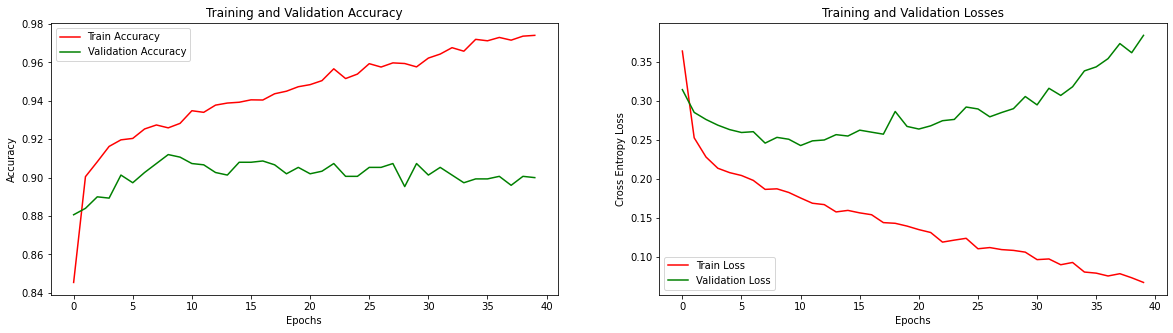

In [85]:

resnet18_entire_exp_model = copy.deepcopy(resnet18_entire)

# unfreezing Conv Layers of block 4
print(resnet18_entire_exp_model.layer4)
for param in resnet18_entire_exp_model.layer4.parameters():
    param.requires_grad = True

resnet18_entire_exp_criterion = nn.CrossEntropyLoss()

resnet18_entire_exp_optimizer = optim.SGD(resnet18_entire_exp_model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.00001)

resnet18_entire_exp_history, resnet18_entire_exp_best_model = train(model = resnet18_entire_exp_model,
                                       criterion = resnet18_entire_exp_criterion,
                                       optimizer = resnet18_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_entire_exp_1.pth',
                                       epochs=40)


Train Accuracy: 0.9830 | F1 Score: 0.9855
Validation Accuracy: 0.9000 | F1 Score: 0.9132
Test Accuracy: 0.9460 | F1 Score: 0.9537


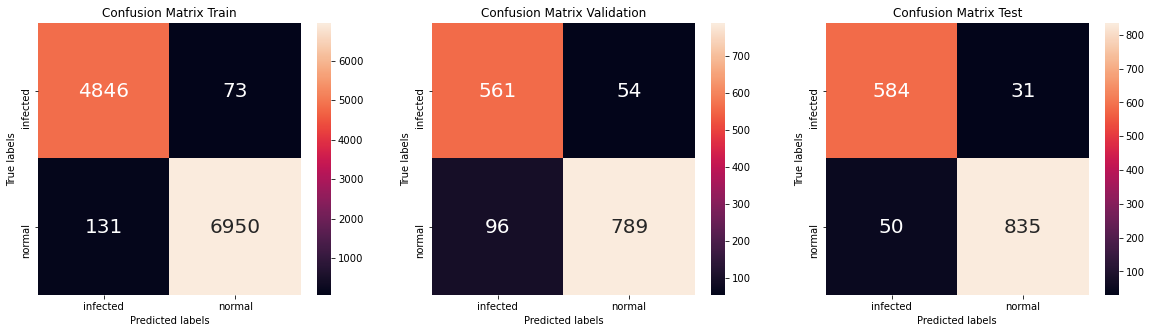

In [87]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_entire_exp_logs.append({'desc': '1 Block', 'results': results, 'history': resnet18_entire_exp_history})


### EXP 2: Unfreeze 2 blocks of Features

Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:52<00:00, 229.84it/s]
Train Loss: 0.334539 | Validation Loss: 0.277346 | Train Accuracy: 0.86 | Validation Accuracy: 0.89
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:54<00:00, 221.09it/s]
Train Loss: 0.222309 | Validation Loss: 0.247607 | Train Accuracy: 0.91 | Validation Accuracy: 0.90
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:56<00:00, 214.01it/s]
Train Loss: 0.200076 | Validation Loss: 0.238484 | Train Accuracy: 0.92 | Validation Accuracy: 0.91
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:56<00:00, 211.38it/s]
Train Loss: 0.193139 | Validation Loss: 0.237565 | Train Accuracy: 0.92 | Validation Accuracy: 0.91
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:55<00:00, 217.31it/s]


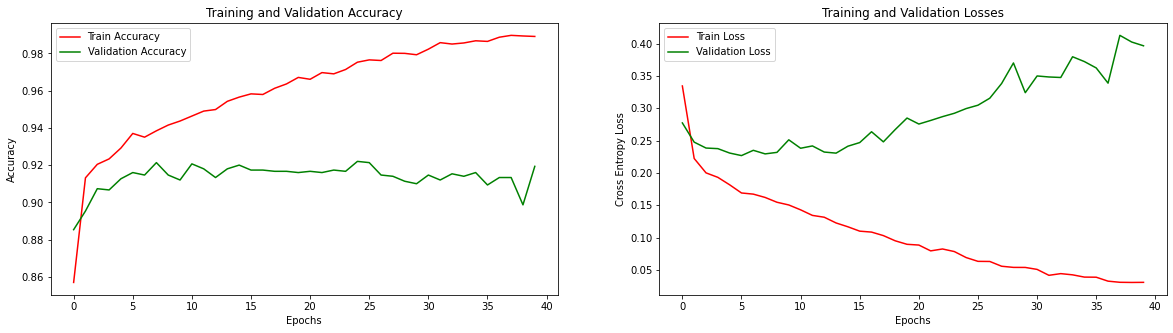

In [88]:

resnet18_entire_exp_model = copy.deepcopy(resnet18_entire)

# unfreezing Conv Layers of block 4 and block 3
for param in resnet18_entire_exp_model.layer4.parameters():
    param.requires_grad = True
    
for param in resnet18_entire_exp_model.layer3.parameters():
    param.requires_grad = True

resnet18_entire_exp_criterion = nn.CrossEntropyLoss()

resnet18_entire_exp_optimizer = optim.SGD(resnet18_entire_exp_model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.00001)

resnet18_entire_exp_history, resnet18_entire_exp_best_model = train(model = resnet18_entire_exp_model,
                                       criterion = resnet18_entire_exp_criterion,
                                       optimizer = resnet18_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_entire_exp_2.pth',
                                       epochs=40)

Train Accuracy: 0.9928 | F1 Score: 0.9939
Validation Accuracy: 0.9193 | F1 Score: 0.9318
Test Accuracy: 0.9633 | F1 Score: 0.9690


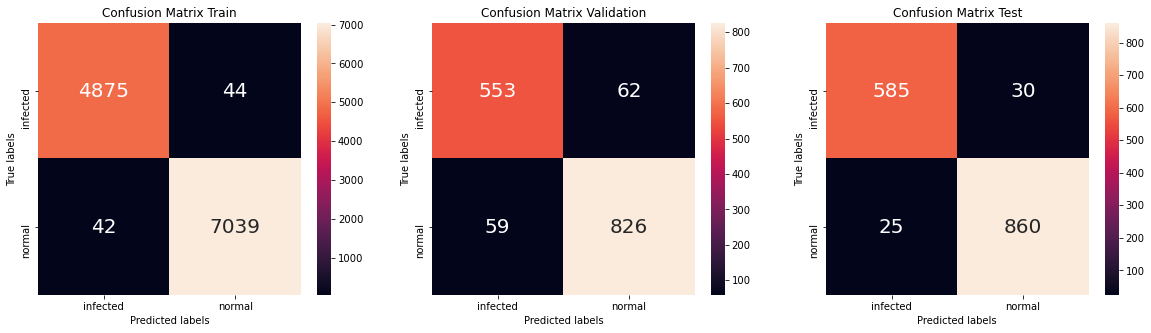

In [89]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_entire_exp_logs.append({'desc': '2 Blocks', 'results': results, 'history': resnet18_entire_exp_history})


### EXP 3: Unfreeze whole network

Train Epoch: 1 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:58<00:00, 204.43it/s]
Train Loss: 0.317264 | Validation Loss: 0.258841 | Train Accuracy: 0.87 | Validation Accuracy: 0.90
Train Epoch: 2 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:59<00:00, 203.07it/s]
Train Loss: 0.214109 | Validation Loss: 0.241183 | Train Accuracy: 0.91 | Validation Accuracy: 0.90
Train Epoch: 3 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:59<00:00, 202.93it/s]
Train Loss: 0.187142 | Validation Loss: 0.248398 | Train Accuracy: 0.93 | Validation Accuracy: 0.90
Train Epoch: 4 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:59<00:00, 202.48it/s]
Train Loss: 0.173723 | Validation Loss: 0.229167 | Train Accuracy: 0.93 | Validation Accuracy: 0.91
Train Epoch: 5 / 40: 100%|██████████████████████████████████████████████████████| 12000/12000 [00:59<00:00, 202.06it/s]


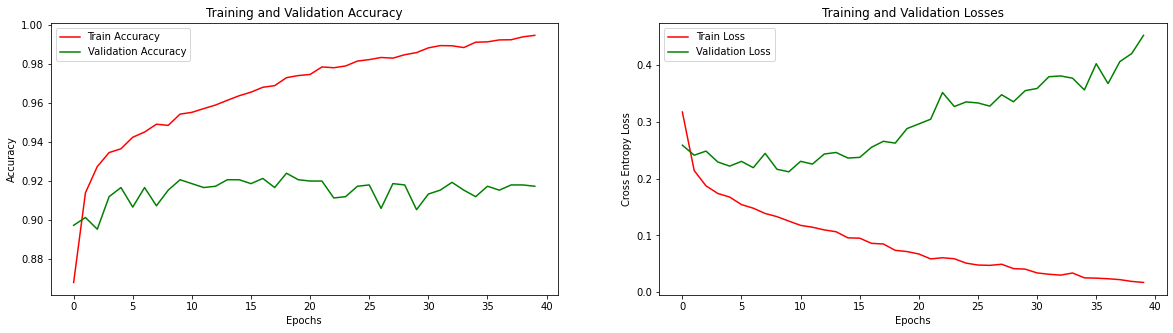

In [91]:

resnet18_entire_exp_model = copy.deepcopy(resnet18_entire)

# unfreezing all Layers
for param in resnet18_entire.parameters():
    param.requires_grad = True
    

resnet18_entire_exp_criterion = nn.CrossEntropyLoss()

resnet18_entire_exp_optimizer = optim.SGD(resnet18_entire_exp_model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.00001)

resnet18_entire_exp_history, resnet18_entire_exp_best_model = train(model = resnet18_entire_exp_model,
                                       criterion = resnet18_entire_exp_criterion,
                                       optimizer = resnet18_entire_exp_optimizer,
                                       train_loader = trainloader,
                                       validation_loader = validationloader,
                                       save_path = 'resnet18_entire_exp_3.pth',
                                       epochs=40)

Train Accuracy: 0.9960 | F1 Score: 0.9966
Validation Accuracy: 0.9173 | F1 Score: 0.9314
Test Accuracy: 0.9713 | F1 Score: 0.9762


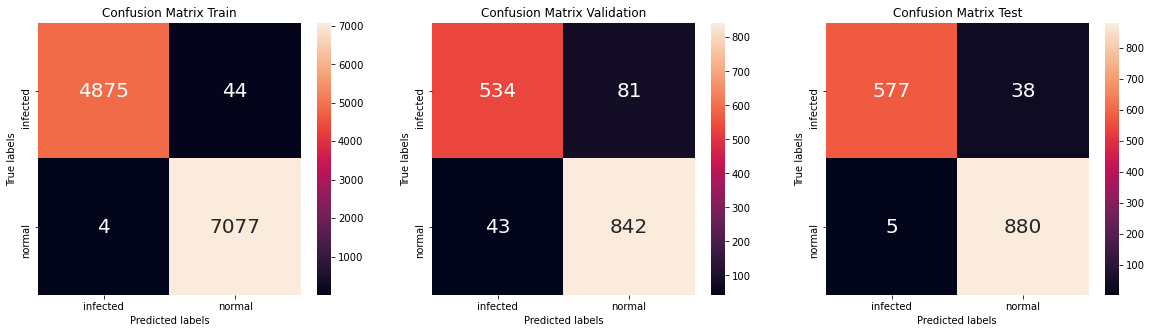

In [92]:
_, _, acc_train, cm_train, f1_score_train = evaluate_model(resnet18_entire_exp_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(resnet18_entire_exp_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(resnet18_entire_exp_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])

results= {
    'acc_train': acc_train,
    'acc_val': acc_val,
    'acc_test': acc_test,
    'f1_score_train': f1_score_train,
    'f1_score_val': f1_score_val,
    'f1_score_test': f1_score_test}

resnet18_entire_exp_logs.append({'desc': 'Entire Network', 'results': results, 'history': resnet18_entire_exp_history})


In [93]:
# model trained in experiment 3 is entire trained model and already saved on disk, so just making copy of it with new name
shutil.copy2('best models/resnet18_entire_exp_3.pth', 'resnet18_entire.pth')

'resnet18_entire.pth'

<br><br><br><center><h1>RESULTS</h1></center><br><br><br>

In [17]:
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)

In [23]:
def best_worst_clasified_images(model, data_loader):

    criterion = nn.CrossEntropyLoss()
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    best = []
    worst = []
    with torch.no_grad():
        for cls, label in enumerate(labels):
            best_count = 0
            worst_count = 0
            for inputs, classes in data_loader:
                inputs, classes = inputs.to(device), classes.to(device)
                outputs = model(inputs)               #----> forward pass
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, classes)   #----> compute loss
                if predicted.item() == cls and best_count < 2:
                    image = np.squeeze(inputs.cpu().numpy()).transpose((1,2,0))
                    image = np.clip(std * image + mean, 0, 1)
                    best.append({'pred': predicted.item(), 'true': cls, 'img': image})
                    best_count+=1
                    
                elif predicted.item() != cls and worst_count < 2:
                    image = np.squeeze(inputs.cpu().numpy()).transpose((1,2,0))
                    image = np.clip(std * image + mean, 0, 1)
                    worst.append({'pred': predicted.item(), 'true': cls, 'img': image})
                    worst_count+=1
                    
                if best_count == worst_count == 2:
                    break

    
    fig, ax =  plt.subplots(2,4,figsize=(15,8))
    
    for idx , (pred_best, pred_worst) in enumerate(zip(best, worst)):
        ax[0, idx].imshow(pred_best['img'])
        ax[0, idx].set_title('Predicted: %s \n Ground Truth: %s'%(labels[pred_best['pred']], labels[pred_best['true']]), color='g')
        
        ax[1, idx].imshow(pred_worst['img'])
        ax[1, idx].set_title('Predicted: %s \n Ground Truth: %s'%(labels[pred_worst['pred']], labels[pred_worst['true']]), color='r')
    
    
    plt.show()

## VGG16 FC only

In [20]:
test_model = load_pretrained_model('vgg16')
test_model.load_state_dict(torch.load('vgg16_FC_Only.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 0.9414 | F1 Score: 0.9508
Validation Accuracy: 0.8980 | F1 Score: 0.9133
Test Accuracy: 0.9553 | F1 Score: 0.9626


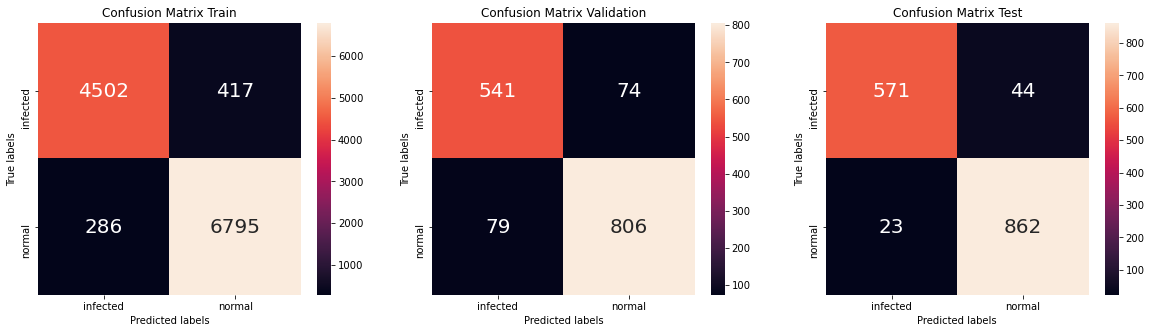

In [38]:


_, _, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(test_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])


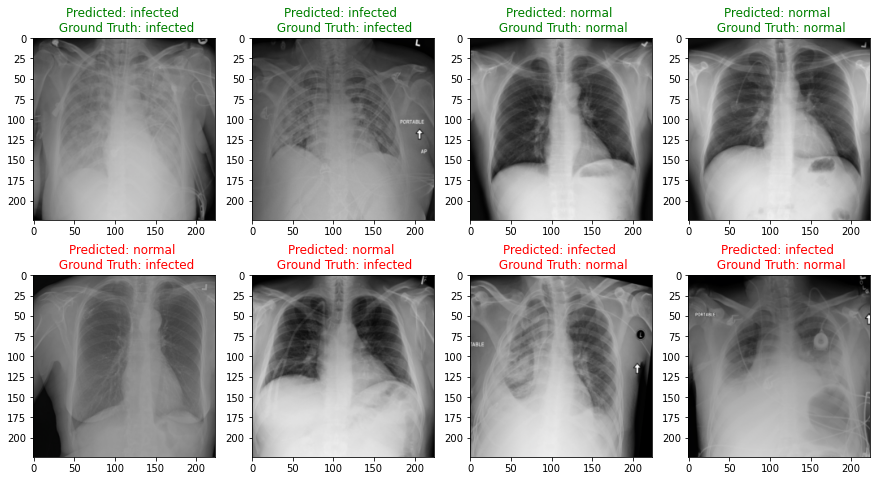

In [24]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
best_worst_clasified_images(test_model, testloader)

# ResNet18 FC Only

In [31]:
test_model = load_pretrained_model('resnet18')
test_model.load_state_dict(torch.load('resnet18_FC_Only.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 0.9028 | F1 Score: 0.9204
Validation Accuracy: 0.8767 | F1 Score: 0.8976
Test Accuracy: 0.9360 | F1 Score: 0.9470


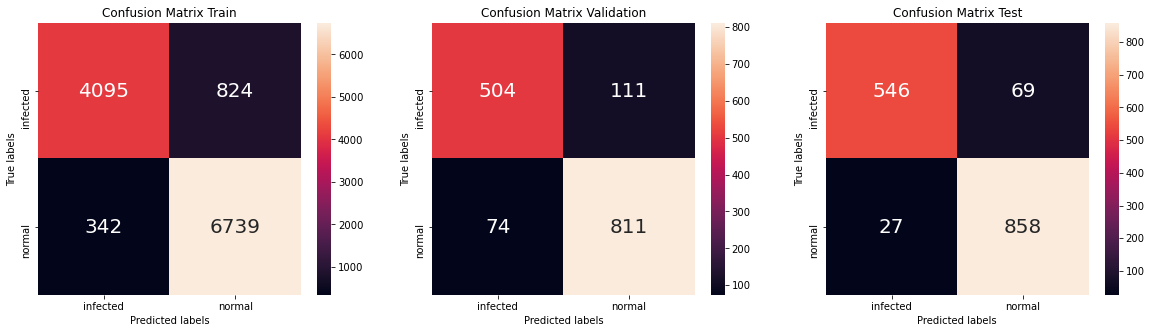

In [32]:


_, _, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(test_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])




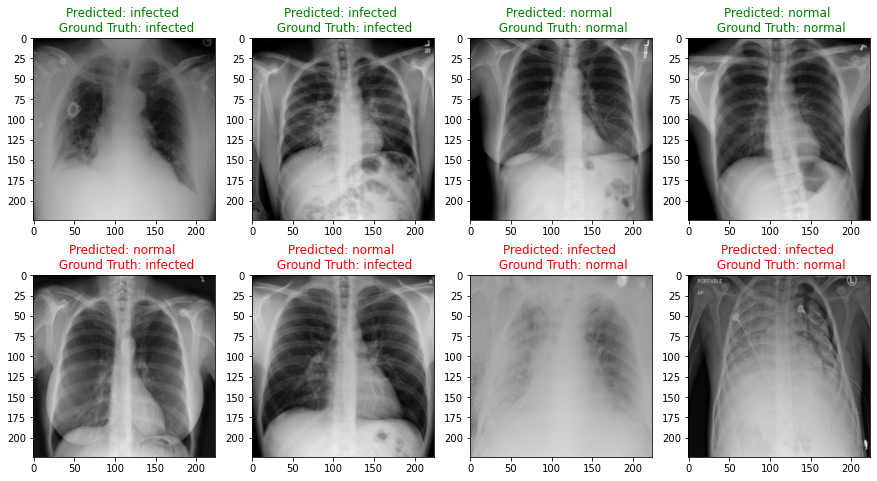

In [25]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
best_worst_clasified_images(test_model, testloader)

# VGG16 Entire

In [33]:
test_model = load_pretrained_model('vgg16')
test_model.load_state_dict(torch.load('vgg16_entire.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Train Accuracy: 0.9751 | F1 Score: 0.9789
Validation Accuracy: 0.9260 | F1 Score: 0.9373
Test Accuracy: 0.9793 | F1 Score: 0.9825


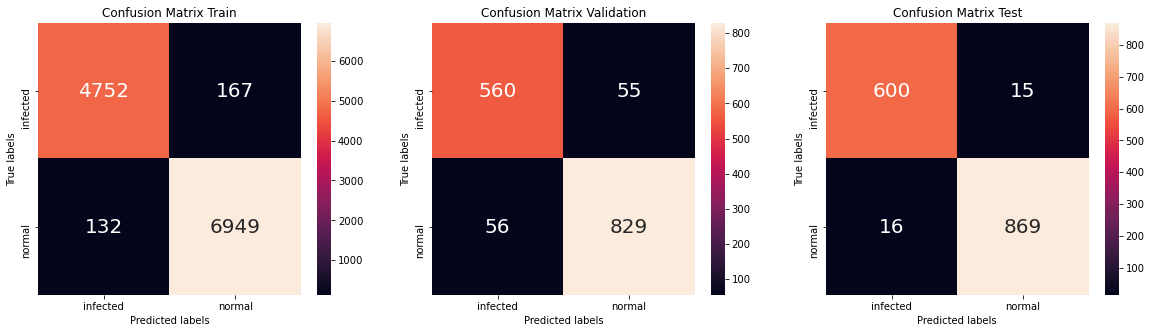

In [34]:


_, _, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(test_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])



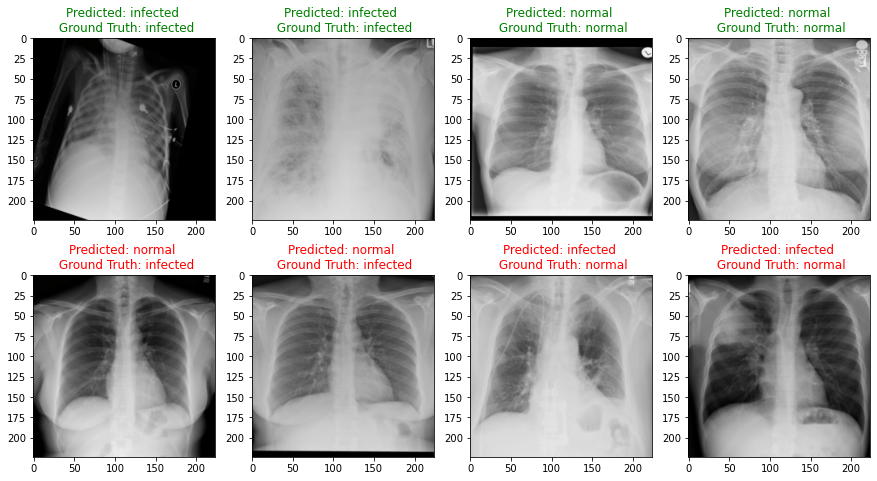

In [26]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
best_worst_clasified_images(test_model, testloader)

# ResNet18 Entire

In [35]:
test_model = load_pretrained_model('resnet18')
test_model.load_state_dict(torch.load('resnet18_entire.pth'))
test_model.to(device)
print()

Loading Model...
Model Loaded



Train Accuracy: 0.9810 | F1 Score: 0.9840
Validation Accuracy: 0.9240 | F1 Score: 0.9360
Test Accuracy: 0.9713 | F1 Score: 0.9759


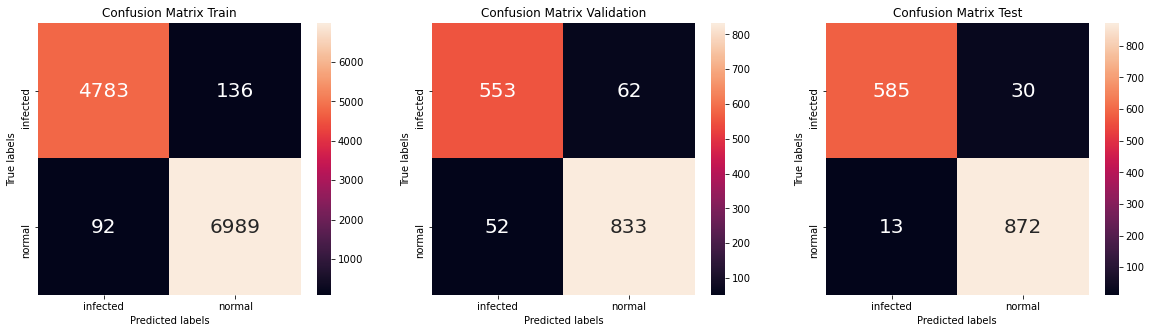

In [36]:

_, _, acc_train, cm_train, f1_score_train = evaluate_model(test_model, trainloader)
_, _, acc_val, cm_val, f1_score_val = evaluate_model(test_model, validationloader)
_, _, acc_test, cm_test, f1_score_test = evaluate_model(test_model, testloader)

print('Train Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_train, f1_score_train))
print('Validation Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_val, f1_score_val))
print('Test Accuracy: {:.4f} | F1 Score: {:.4f}'.format(acc_test, f1_score_test))

plot_confusion_matrices(cm=[cm_train, cm_val, cm_test], labels=labels, titles=['Confusion Matrix Train', 'Confusion Matrix Validation', 'Confusion Matrix Test'])


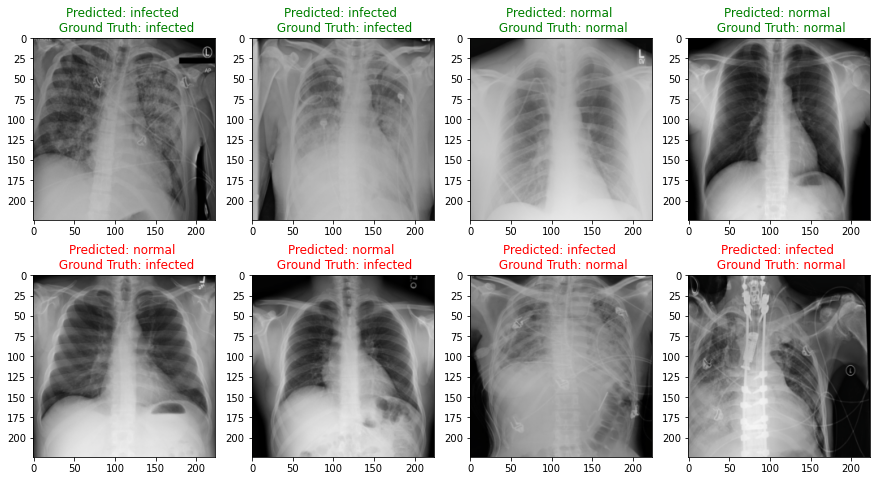

In [27]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
best_worst_clasified_images(test_model, testloader)